# Proyek Sistem Rekomendasi: [Movie Rating Dataset](https://www.kaggle.com/datasets/rockyt07/movie-rating-dataset?select=movies.csv)
- **Nama:** [Sinta Ezra Wati Gulo]
- **Email:** [sintaezra04@gmail.com]
- **ID Dicoding:** [sinta_ezra]

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping

## Data Understanding

Selanjutnya adalah memahami data, untuk memahami data dapat dilakukan dalam beberapa tahapan berikut:

- Data loading
- Exploratory Data Analysis

### Data Loading

**1. Memuat dan menampilkan informasi kondisi data `df_movies`**

In [2]:
# Load df_movies
df_movies = pd.read_csv('data/movies.csv')

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Output kode di atas memberikan informasi sebagai berikut:

- Ada 9.742 baris dalam dataset.
- Terdapat 3 kolom yaitu:  
  - `movieId`: ID unik untuk setiap film.
  - `title`: Judul film yang mencakup tahun rilis dalam tanda kurung untuk mengenali film secara spesifik, terutama jika terdapat film dengan nama serupa yang dirilis di tahun berbeda.
  - `genres`: Kategori/genre film, dipisahkan oleh karakter | jika lebih dari satu genre.
- Terdapat 1 kolom numerik dengan tipe data int64 yaitu movieId, serta 2 kolom kategorik dengan tipe data object yaitu title dan genres.

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_movies.isnull().sum()

,0
movieId,0
title,0
genres,0


Output di atas menunjukkan tidak ada missing value pada df_movies.

In [6]:
print('Jumlah data duplikat pada df_movies: ', df_movies.duplicated().sum())

Jumlah data duplikat pada df_movies:  0


Output di atas menunjukkan tidak ada data duplikat pada df_movies.

**2. Memuat dan menampilkan informasi kondisi data `df_ratings`**

In [7]:
# Load df_ratings
df_ratings = pd.read_csv('data/ratings.csv')

In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Output di atas menunjukkan informasi sebagai berikut:
- Ada 100.836 baris dalam dataset.
- Terdapat 4 kolom yaitu:
  - `userId`: ID unik untuk setiap user.
  - `movieId`: ID unik untuk setiap film.
  - `rating`: Menunjukkan skor atau penilaian yang diberikan oleh pengguna terhadap suatu film dengan skala 0-5.
  - `timestamp`: Mencatat waktu ketika rating diberikan.
- Berisi data numerik dengan 1 kolom bertipe float64 yaitu rating dan 3 kolom bertipe int64 yaitu userId, movieId, dan timestamp.


In [9]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
df_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Output di atas menunjukkan tidak ada missing value pada df_ratings.

In [11]:
print('Jumlah data duplikat pada df_ratings: ', df_ratings.duplicated().sum())

Jumlah data duplikat pada df_ratings:  0


Output di atas menunjukkan tidak ada data duplikat pada df_ratings.

In [12]:
df_ratings['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


**Insight:**
- Terdapat 100.836 rating dalam dataset, yang menunjukkan volume interaksi pengguna dengan film cukup tinggi.
- Nilai minimum adalah 0.5, dan maksimum adalah 5.0, yang menunjukkan bahwa pengguna menggunakan seluruh skala rating yang tersedia.
- Nilai rata-rata rating adalah 3.50 dari skala 0.5–5.0. Ini menunjukkan bahwa secara umum, pengguna cenderung memberikan penilaian yang positif atau netral terhadap film yang mereka tonton.

**3. Memuat dan menampilkan informasi kondisi data `df_tags`**

In [13]:
# Load df_tags
df_tags = pd.read_csv('data/tags.csv')

In [14]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Output di atas menunjukkan informasi sebagai berikut:
- Ada 3.683 baris dalam dataset.
- Terdapat 4 kolom yaitu:
  - `userId`: ID unik untuk setiap user.
  - `movieId`: ID unik untuk setiap film.
  - `tag`: Menunjukkan ata kunci atau frasa pendek yang diberikan oleh pengguna untuk menggambarkan film tersebut.
  - `timestamp`: Mencatat waktu ketika tag diberikan.
- Berisi 3 kolom numerik dengan tipe data int64 yaitu userId, movieId, dan timestamp, serta 1 kolom kategorik dengan tipe data object yaitu tag.


In [15]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [16]:
df_tags.isnull().sum()

,0
userId,0
movieId,0
tag,0
timestamp,0


Output di atas menunjukkan tidak ada missing value pada df_tags.

In [17]:
print('Jumlah data duplikat pada df_tags: ', df_tags.duplicated().sum())

Jumlah data duplikat pada df_tags:  0


Output di atas menunjukkan tidak ada data duplikat pada df_tags.

### Exploratory Data Analysis

**1. Melakukan EDA pada `df_movies`**

In [18]:
df_movies['movieId'].nunique()

9742

Output di atas menunjukkan bahwa ada 9.742 ID movie berbeda pada df_movies.

<Axes: title={'center': 'Distribusi Film per Tahun'}, xlabel='Tahun', ylabel='Jumlah Film'>

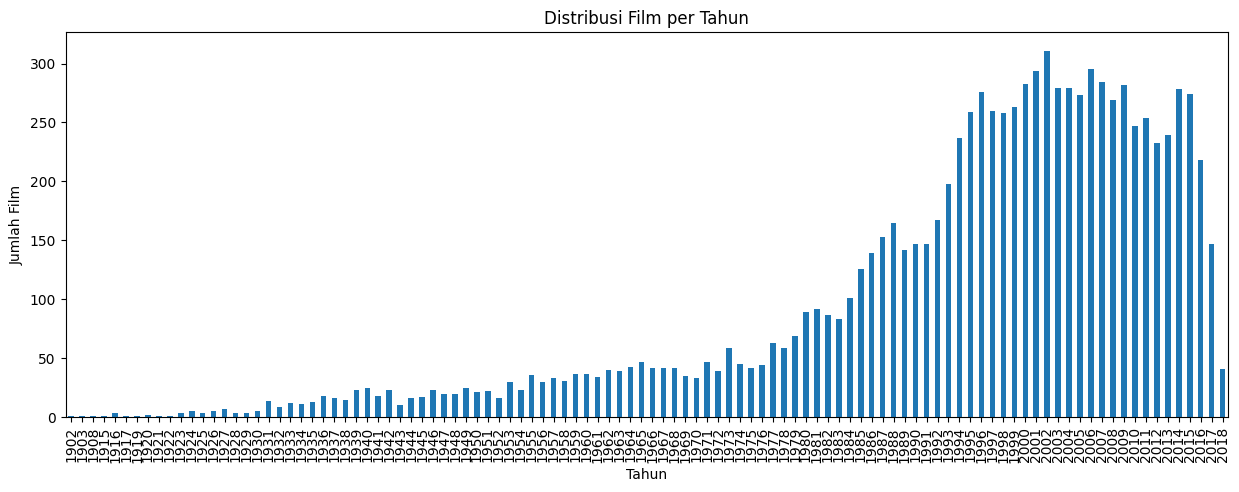

In [19]:
# Melihat distribusi film per tahun
df_movies['title'].str.extract(r'\((\d{4})\)', expand=True).rename(columns={0: 'Tahun'})['Tahun'] \
    .dropna().astype(int).value_counts().sort_index().plot(kind='bar', figsize=(15,5), title='Distribusi Film per Tahun', xlabel='Tahun', ylabel='Jumlah Film')

**Insight:**
- Jumlah film meningkat tajam dari tahun 1990 hingga 2010, yang berarti terdapat lebih banyak pilihan film modern dalam data.
- Puncak jumlah film per tahun terjadi sekitar 2008–2010, dengan lebih dari 300 film dirilis pada tahun-tahun tersebut.

In [20]:
unique_genres = set(g for genre_str in df_movies['genres'] for g in genre_str.split('|'))
print(f"Jumlah genre unik: {len(unique_genres)}")
print(f"Daftar genre: {sorted(unique_genres)}")

Jumlah genre unik: 20
Daftar genre: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


**Insight:**
- Terdapat 20 genre unik dalam dataset, menunjukkan keragaman tema film yang cukup luas.
- Adanya label (no genres listed) menunjukkan beberapa film tidak memiliki informasi genre, sehingga perlu penanganan khusus dalam sistem rekomendasi.

<Axes: title={'center': 'Distribusi Genre'}, xlabel='Genre', ylabel='Jumlah Film'>

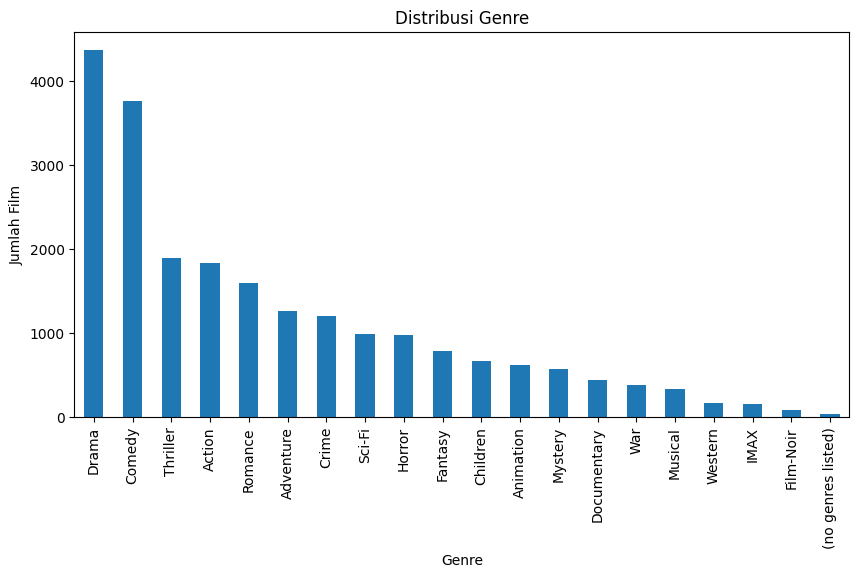

In [21]:
# Melihat distribusi genre
genre_freq = Counter()
for genre_str in df_movies['genres']:
    genre_freq.update(genre_str.split('|'))

# Visualisasi
pd.Series(genre_freq).sort_values(ascending=False).plot(kind='bar', title='Distribusi Genre', figsize=(10,5), xlabel='Genre', ylabel='Jumlah Film' )

**Insight:**
- Genre Drama dan Comedy merupakan yang paling dominan, masing-masing dengan lebih dari 4000 dan 3700 film.
- Genre seperti Thriller, Action, dan Romance juga memiliki jumlah film yang signifikan, menjadikannya pilihan umum untuk rekomendasi berbasis genre populer.
- Genre dengan jumlah film lebih sedikit seperti Film-Noir, IMAX, dan Western cocok untuk pengguna dengan preferensi khusus atau sebagai rekomendasi yang lebih niche.
- Genre (no genres listed) menunjukkan adanya film tanpa label genre, yang sebaiknya ditangani melihat distribusinya kecil pada data.

<Axes: title={'center': 'Jumlah Genre per Film'}, xlabel='Jumlah Genre', ylabel='Jumlah Film'>

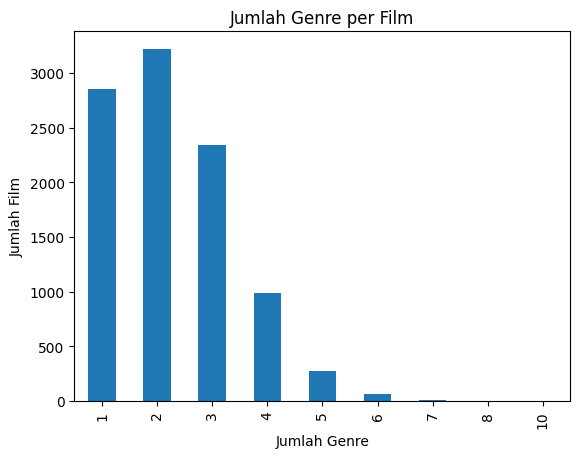

In [22]:
genre_count_series = df_movies['genres'].apply(lambda x: len(x.split('|')))
genre_count_series.value_counts().sort_index().plot(kind='bar', title='Jumlah Genre per Film', xlabel='Jumlah Genre', ylabel='Jumlah Film')

**Insight:**
- Sebagian besar film hanya memiliki 1 hingga 3 genre, menunjukkan bahwa mayoritas film memiliki fokus genre yang jelas.
- Film dengan 2 genre paling umum, menunjukkan tren penggabungan genre populer.
- Jumlah film dengan lebih dari 3 genre menurun drastis, menunjukkan bahwa film multi-genre kompleks lebih jarang.

**2. Melakukan EDA pada `df_ratings`**

<Axes: title={'center': 'Distribusi Rating'}, xlabel='Rating', ylabel='Jumlah'>

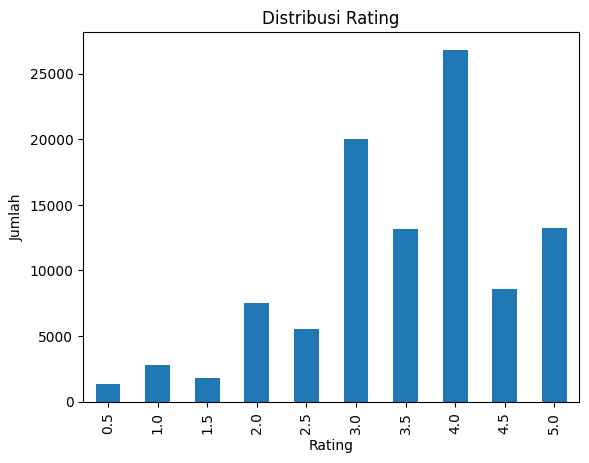

In [23]:
# Menampilkan distribusi rating
df_ratings['rating'].value_counts().sort_index().plot(kind='bar', title='Distribusi Rating', xlabel='Rating', ylabel='Jumlah')

**Insight:**
- Rating 4.0 merupakan yang paling sering diberikan, menandakan banyak pengguna cenderung memberi penilaian positif.
- Rating 3.0 dan 5.0 juga memiliki jumlah signifikan, menunjukkan kecenderungan pengguna menilai film secara moderat atau sangat baik.
- Rating di bawah 2.5 relatif jarang, yang bisa menunjukkan bias pengguna terhadap film yang memang sudah disukai.

<Axes: title={'center': 'Jumlah Rating per User'}, xlabel='Jumlah Rating yang Diberikan User', ylabel='Jumlah User'>

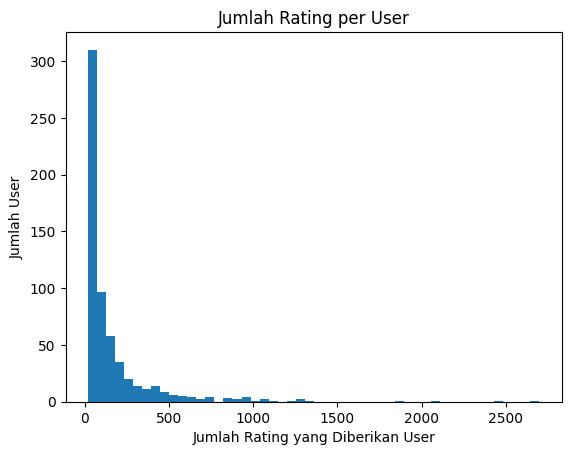

In [24]:
df_ratings['userId'].value_counts().plot(
    kind='hist',
    bins=50,
    title='Jumlah Rating per User',
    xlabel='Jumlah Rating yang Diberikan User',
    ylabel='Jumlah User'
)

**Insight:**
- Sebagian besar pengguna memberikan kurang dari 100 rating, menunjukkan banyak pengguna yang kurang aktif.
- Hanya sedikit pengguna yang memberikan lebih dari 1000 rating, menandakan adanya segelintir pengguna sangat aktif (power users).

<Axes: title={'center': 'Jumlah Rating per Film'}, xlabel='Jumlah Rating yang Diterima Film', ylabel='Jumlah Film'>

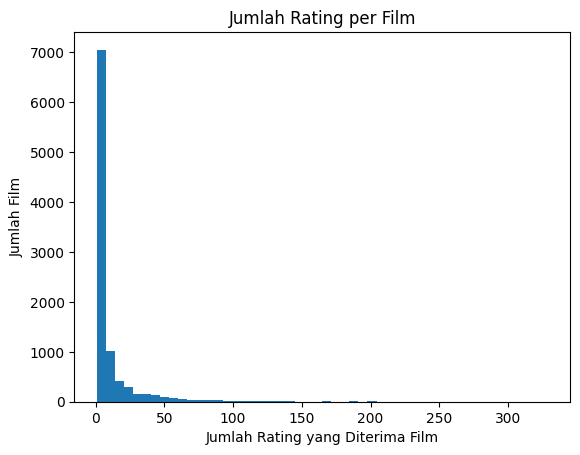

In [25]:
df_ratings['movieId'].value_counts().plot(
    kind='hist',
    bins=50,
    title='Jumlah Rating per Film',
    xlabel='Jumlah Rating yang Diterima Film',
    ylabel='Jumlah Film'
)

**Insight:**
- Sebagian besar film hanya menerima sedikit rating, menunjukkan banyak film kurang populer atau jarang ditonton.
- Hanya sebagian kecil film yang menerima banyak rating, menandakan adanya film-film populer atau ikonik.

In [26]:
df_ratings['movieId'].value_counts().head(10)

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
260,251
480,238
110,237
589,224


Output di atas menunjukkan top 10 film dengan jumlah rating terbanyak, dimana ID 356 adalah yang paling sering diberi rating, yaitu sebanyak 329 kali.

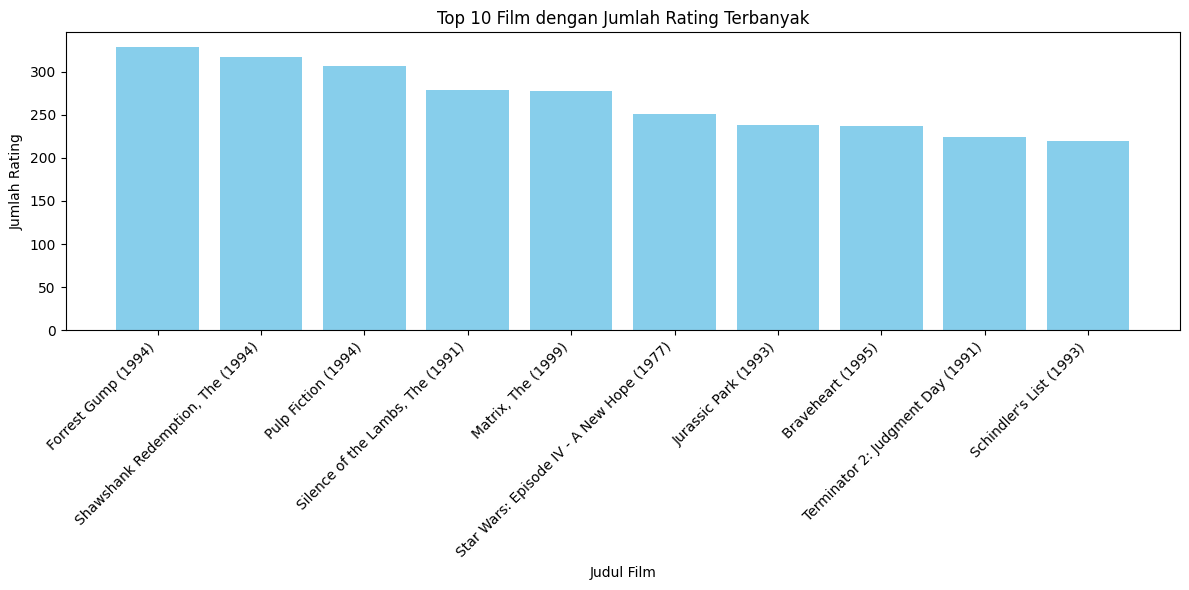

In [27]:
# Mendefinisikan count sebagai hasil value_counts() pada movieId
count = df_ratings['movieId'].value_counts()

# Mengubah hasilnya jadi DataFrame terlebih dahulu
count_df = count.rename('rating_count').reset_index().rename(columns={'index': 'movieId'})

# Merge dengan df_movies yang punya kolom movieId dan title
merged = count_df.merge(df_movies[['movieId', 'title']], on='movieId')

# Menampilkan hasilnya
top10 = merged.head(10)

plt.figure(figsize=(12,6))
plt.bar(top10['title'], top10['rating_count'], color='skyblue')
plt.title('Top 10 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Judul Film')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Output di atas menunjukkan judul-judul film yang menjadi top 10 film dengan rating terbanyak, dimana film klasik dari era 1990-an mendominasi daftar ini, menandakan daya tarik jangka panjang dan pengenalan luas oleh penonton.

**3. Melakukan EDA pada `df_tags`**

In [28]:
print(f"Jumlah tag unik: {df_tags['tag'].nunique()}")

Jumlah tag unik: 1589


Output di atas menunjukkan bahwa terdapat 1.589 tag unik pada df_tags.

<Axes: title={'center': 'Top 10 Tag Paling Sering Muncul'}, xlabel='tag'>

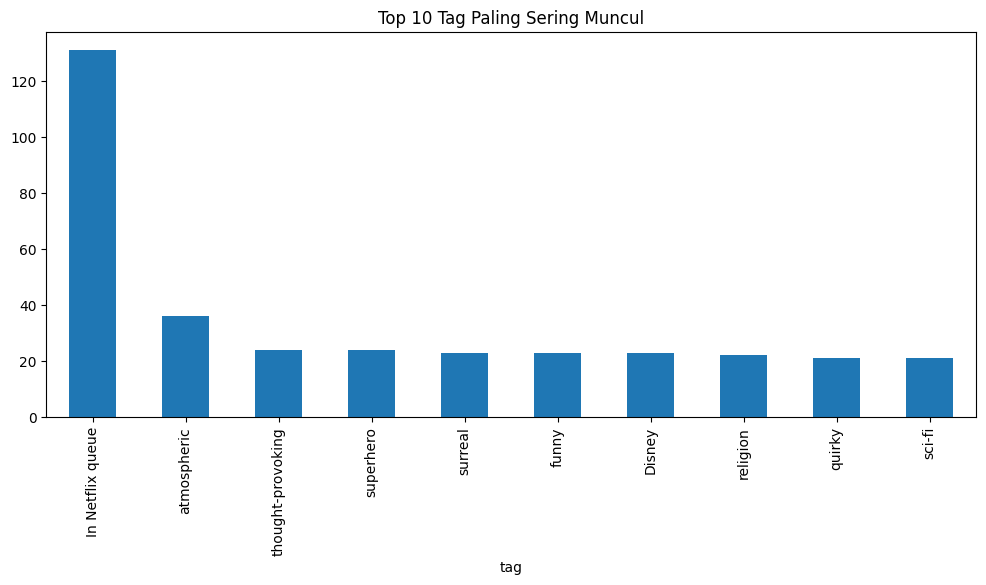

In [29]:
df_tags['tag'].value_counts().head(10).plot(kind='bar', figsize=(12,5), title='Top 10 Tag Paling Sering Muncul')

**Insight:**
- Output di atas menunjukkan top 10 tag paling banyak atau sering muncul.
- Tag In Netflix queue muncul paling banyak, jauh melampaui tag lainnya. Ini menunjukkan bahwa banyak pengguna menandai film bukan berdasarkan konten atau genre, tetapi sebagai daftar tontonan atau preferensi pribadi untuk ditonton nanti.
- Tag-tag berikutnya mencerminkan karakteristik atau tema film.

<Axes: title={'center': 'Top 10 Tag Paling Jarang Muncul'}, xlabel='tag'>

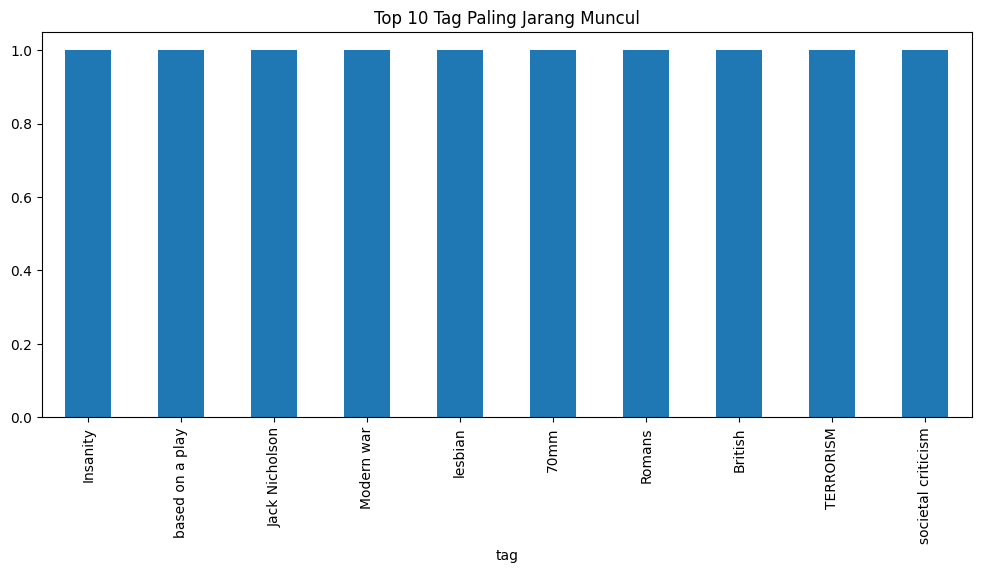

In [30]:
df_tags['tag'].value_counts().tail(10).plot(kind='bar', figsize=(12,5), title='Top 10 Tag Paling Jarang Muncul')

**Insight:**
- Output di atas menunjukkan Top 10 Tag Paling Jarang Muncul.
- Semua tag hanya muncul 1 kali, menunjukkan bahwa tag-tag ini sangat jarang digunakan oleh pengguna. Ini bisa menandakan niche interest atau ketidakkonsistenan dalam proses penandaan.

<Axes: title={'center': 'Jumlah Tag per Film'}, xlabel='Jumlah Tag', ylabel='Jumlah Film'>

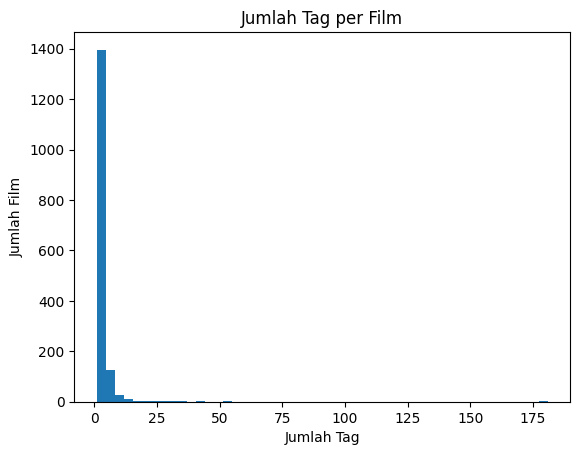

In [31]:
df_tags['movieId'].value_counts().plot(kind='hist', bins=50, title='Jumlah Tag per Film', xlabel='Jumlah Tag', ylabel='Jumlah Film')

**Insight:**
- Sebagian besar film hanya memiliki 1–2 tag, dengan lebih dari 1400 film hanya memiliki 1 tag saja.
- Hanya sebagian kecil pengguna yang aktif memberi banyak tag pada film tertentu. Sebaliknya, mayoritas film hampir tidak diberi tag.

<Axes: title={'center': 'Jumlah Tag per User'}, xlabel='Jumlah Tag', ylabel='Jumlah User'>

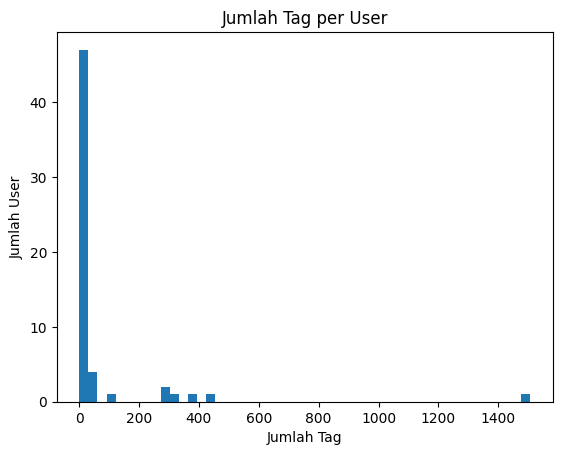

In [32]:
df_tags['userId'].value_counts().plot(kind='hist', bins=50, title='Jumlah Tag per User', xlabel='Jumlah Tag', ylabel='Jumlah User')

**Insight:**
- Sebagian besar user hanya memberikan kurang dari 10 tag, bahkan banyak yang hanya memberi 1–2 tag saja.
- Hanya segelintir user yang sangat aktif memberi ratusan bahkan >1000 tag.

## Data Preparation

Pada bagian ini akan dilakukan beberapa tahap persiapan data, yaitu:
1. Data Preparation untuk Content Based Filtering
 - Menghapus data dengan genres = (no genres listed) pada df_movies
 - Menggabungkan tag berdasarkan movieId
 - Menggabungkan df_movies dengan tags_agg berdasarkan movieId
 - Menangani missing value pada movies_tags
 - Membuat kolom gabungan antara genres dan tag dengan nama content
3. Data Preparation untuk Collaborative Filtering
  - Melakukan Encoding pada userId dan movieId
  - Melakukan normalisasi pada rating
  - Split data train dan validasi

### Data Preparation untuk Content Based Filtering

**1. Menghapus data dengan genres = (no genres listed) pada df_movies**

In [33]:
# Cek jumlah baris dengan genres = '(no listed)'
jumlah_no_listed = df_movies[df_movies['genres'] == '(no genres listed)'].shape[0]
print(f"Jumlah data dengan genres = '(no genres listed)': {jumlah_no_listed}")
print(f"Jumlah baris sebelum penghapusan: {df_movies.shape[0]}")

Jumlah data dengan genres = '(no genres listed)': 34
Jumlah baris sebelum penghapusan: 9742


Output di atas menunjukkan bahwa terdapat sebanyak 34 data yang tidak memiliki genre, sehingga bisa dilanjutkan dengan menghapus data tersebut agar data siap untuk digunakan. Adapun jumlah data sebelum menghapus data yang tidak memiliki genre adalah 9.742

In [34]:
# Hapus baris dengan nilai genres = '(no genres listed)'
df_movies = df_movies[df_movies['genres'] != '(no genres listed)']
print(f"Jumlah baris setelah penghapusan: {df_movies.shape[0]}")

Jumlah baris setelah penghapusan: 9708


Kode di atas menghapus data df_movies yang tidak memiliki genre, sehingga data tersisa adalah 9.708

**2. Menggabungkan tag berdasarkan movieId**

In [35]:
tags_agg = df_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
tags_agg

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake
...,...,...
1567,183611,Comedy funny Rachel McAdams
1568,184471,adventure Alicia Vikander video game adaptation
1569,187593,Josh Brolin Ryan Reynolds sarcasm
1570,187595,Emilia Clarke star wars


**3. Menggabungkan df_movies dengan tags_agg berdasarkan movieId**

In [36]:
movies_tags = pd.merge(df_movies, tags_agg, on='movieId', how='left')
movies_tags

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake
...,...,...,...,...
9703,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,NaN
9704,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,NaN
9705,193585,Flint (2017),Drama,NaN
9706,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,NaN


Dari hasil di atas, dapat dilihat bahwa ada beberapa data yang tag nya tidak memiliki nilai (missing value), sehingga perlu ditangani pada langkah selanjutnya.

**4. Menangani missing value pada movies_tags**

In [37]:
# Cek jumlah missing value
movies_tags.isnull().sum()

,0
movieId,0
title,0
genres,0
tag,8137


Hasil di atas menunjukkan bahwa missing value pada tag ada banyak, hampir seluruh data pada movies_tags, sehingga tidak memungkinkan untuk dihapus. Jadi pada tahap ini, kolom tag yang memiliki missing values dapat diisi dengan string kosong (' ').

In [38]:
# Mengisi missing value dengan string kosong
movies_tags['tag'] = movies_tags['tag'].fillna('')

In [39]:
# Cek kembali missing value
movies_tags.isnull().sum()

,0
movieId,0
title,0
genres,0
tag,0


**5. Membuat kolom gabungan antara genres dan tag dengan nama `content`**

In [40]:
movies_tags['content'] = movies_tags['genres'] + ' ' + movies_tags['tag']
movies_tags

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Adventure|Animation|Children|Comedy|Fantasy pi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,Adventure|Children|Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,Comedy|Romance moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake
...,...,...,...,...,...
9703,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,,Action|Animation|Comedy|Fantasy
9704,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,,Animation|Comedy|Fantasy
9705,193585,Flint (2017),Drama,,Drama
9706,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,,Action|Animation


In [41]:
# Memeriksa informasi movies_tags yang baru
movies_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9708 entries, 0 to 9707
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9708 non-null   int64 
 1   title    9708 non-null   object
 2   genres   9708 non-null   object
 3   tag      9708 non-null   object
 4   content  9708 non-null   object
dtypes: int64(1), object(4)
memory usage: 379.3+ KB


In [42]:
# Memeriksa apakah ada missing value
movies_tags.isnull().sum()

,0
movieId,0
title,0
genres,0
tag,0
content,0


In [43]:
# Memeriksa apakah ada data duplikat
print('Jumlah data duplikat pada movies_tags: ', movies_tags.duplicated().sum())

Jumlah data duplikat pada movies_tags:  0


### Data Preparation untuk Collaborative Filtering

**1. Melakukan Encoding pada userId dan movieId**

In [44]:
# Mengambil daftar unik userId dan movieId
user_ids = df_ratings['userId'].unique().tolist()
movie_ids = df_ratings['movieId'].unique().tolist()

# Membuat dictionary mapping userId dan movieId ke angka (encoding)
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Membuat dictionary inverse-nya (dari index ke userId/movieId)
user_encoded_to_user = {i: x for x, i in user_to_user_encoded.items()}
movie_encoded_to_movie = {i: x for x, i in movie_to_movie_encoded.items()}

# Menambahkan kolom user dan movie (hasil encoding) ke dataframe df_ratings
df_ratings['user'] = df_ratings['userId'].map(user_to_user_encoded)
df_ratings['movie'] = df_ratings['movieId'].map(movie_to_movie_encoded)

In [45]:
num_users = len(user_to_user_encoded)
num_movies = len(movie_to_movie_encoded)
print(f'Jumlah user: {num_users}, Jumlah movie: {num_movies}')

Jumlah user: 610, Jumlah movie: 9724


**2. Melakukan normalisasi pada rating**

In [46]:
# Normalisasi rating ke [0,1]
min_rating = df_ratings['rating'].min()
max_rating = df_ratings['rating'].max()
df_ratings['rating_scaled'] = df_ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [47]:
df_ratings.head()

,userId,movieId,rating,timestamp,user,movie,rating_scaled
0,1,1,4.0,964982703,0,0,0.777778
1,1,3,4.0,964981247,0,1,0.777778
2,1,6,4.0,964982224,0,2,0.777778
3,1,47,5.0,964983815,0,3,1.000000
4,1,50,5.0,964982931,0,4,1.000000


**3. Split data train dan validasi**

In [48]:
# Mendefinisikan fitur (user, movie) dan target (rating_scaled)
x = df_ratings[['user', 'movie']].values  # Fitur input
y = df_ratings['rating_scaled'].values    # Target output

# Membagi data menjadi train dan validation set (80:20)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")

x_train shape: (80668, 2)
x_val shape: (20168, 2)


## Modeling

Pada tahap ini dibangun model sistem rekomendasi dengan 2 pendekatan yaitu menggunakan Content-based Filtering dan Collaborative Filtering.

### Model Development dengan Content-Based Filtering

**1. Modeling Content-Based Filtering**

In [49]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 3)
)

tfidf_matrix = tfidf.fit_transform(movies_tags['content'])

# Cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping judul ke index
movie_indices = pd.Series(movies_tags.index, index=movies_tags['title']).drop_duplicates()

# Simpan dalam DataFrame agar mudah diakses
df_sim = pd.DataFrame(cosine_sim, index=movies_tags['title'], columns=movies_tags['title'])

df_sim.iloc[:5, :5]  # Contoh similarity antar 5 film pertama

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995)
title,,,,,
Toy Story (1995),1.000000,0.061581,0.029404,0.020546,0.010770
Jumanji (1995),0.061581,1.000000,0.000000,0.000000,0.000000
Grumpier Old Men (1995),0.029404,0.000000,1.000000,0.284459,0.048557
Waiting to Exhale (1995),0.020546,0.000000,0.284459,1.000000,0.033929
Father of the Bride Part II (1995),0.010770,0.000000,0.048557,0.033929,1.000000


**2. Penerapan Content-Based Filtering**

In [80]:
# Fungsi rekomendasi
def recommend_movies(title, cosine_sim=cosine_sim, top_n=10):
    if title not in movie_indices:
        return []
    idx = movie_indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices_rec = [i[0] for i in sim_scores]
    return movies_tags['title'].iloc[movie_indices_rec]

# Contoh penerapan
print("Rekomendasi untuk 'Toy Story (1995)':")
recommend_movies('Toy Story (1995)')

Rekomendasi untuk 'Toy Story (1995)':


,title
1757,"Bug's Life, A (1998)"
2355,Toy Story 2 (1999)
1706,Antz (1998)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"
6194,"Wild, The (2006)"
6486,Shrek the Third (2007)
6948,"Tale of Despereaux, The (2008)"
7760,Asterix and the Vikings (Astérix et les Viking...


Output di atas menunjukkan hasil rekomendasi content-based filtering untuk film "Toy Story (1995)", yaitu daftar film yang memiliki kemiripan konten dengan Toy Story.

### Model Development dengan Collaborative Filtering

**1. Modeling Collaborative Filtering**

In [51]:
# Model RecommenderNet
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

# Inisialisasi dan compile model
model = RecommenderNet(num_users, num_movies, embedding_size=50)
model.compile(loss=losses.MeanSquaredError(),
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=[metrics.RootMeanSquaredError(), metrics.MeanAbsoluteError()])
# Training
history = model.fit(x=x_train, y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0680 - mean_absolute_error: 0.2159 - root_mean_squared_error: 0.2598 - val_loss: 0.0417 - val_mean_absolute_error: 0.1575 - val_root_mean_squared_error: 0.2013
Epoch 2/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0362 - mean_absolute_error: 0.1445 - root_mean_squared_error: 0.1863 - val_loss: 0.0385 - val_mean_absolute_error: 0.1471 - val_root_mean_squared_error: 0.1906
Epoch 3/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0291 - mean_absolute_error: 0.1244 - root_mean_squared_error: 0.1634 - val_loss: 0.0384 - val_mean_absolute_error: 0.1449 - val_root_mean_squared_error: 0.1880
Epoch 4/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0234 - mean_absolute_error: 0.1064 - root_mean_squared_error: 0.1418 - val_loss: 0.0394 - val_mean_absolute_error: 0.1450 - val_root_mean_squared_error: 0.1883
Epoch 5/20
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0193 - mean_absolute_error: 0.0912 -

**2. Penerapan Collaborative Filtering**

In [82]:
# Untuk memilih satu user
user_id = 365

# Mengambil daftar film yang telah ditonton oleh user tersebut
movies_watched = df_ratings[df_ratings.userId == user_id]

# Menggabungkan dengan data movie untuk mendapatkan informasi judul/genre
watched_movies = movies_watched.merge(df_movies, on='movieId')

# Mengambil seluruh movieId unik dalam dataset
all_movie_ids = df_ratings['movieId'].unique()

# Menyimpan daftar movieId yang belum ditonton user
unwatched_movie_ids = [mid for mid in all_movie_ids if mid not in movies_watched['movieId'].tolist()]

# Encode user_id ke bentuk numerik sesuai mapping yang telah dibuat
user_encoded = user_to_user_encoded[user_id]

# Encode semua movieId yang belum ditonton
movie_encoded_ids = [movie_to_movie_encoded[mid] for mid in unwatched_movie_ids if mid in movie_to_movie_encoded]

# Buat array pasangan (user_encoded, movie_encoded) untuk prediksi
user_movie_array = np.hstack((
    [[user_encoded]] * len(movie_encoded_ids),                        # Kolom user (berulang)
    np.array(movie_encoded_ids).reshape(-1, 1)                        # Kolom movie
))

# Prediksi rating dari model untuk semua film yang belum ditonton
predicted_ratings = model.predict(user_movie_array).flatten()

# Mengambil indeks 10 rating tertinggi
top_indices = predicted_ratings.argsort()[-10:][::-1]

# Mengambil movieId (encoded) dan decode ke movieId asli
top_movie_ids_encoded = [movie_encoded_ids[i] for i in top_indices]
top_movie_ids = [movie_encoded_to_movie[mid] for mid in top_movie_ids_encoded]

# Mengambil data film yang direkomendasikan
recommended_movies = df_movies[df_movies['movieId'].isin(top_movie_ids)]

# Menampilkan 5 film teratas yang diberi rating > 4.0 oleh user
top_rated_movies = movies_watched[movies_watched['rating'] > 4.0] \
                    .sort_values(by='rating', ascending=False) \
                    .merge(df_movies, on='movieId') \
                    .head(5)

print("\n5 film teratas yang diberi rating > 4.0 oleh user", user_id)
print(top_rated_movies[['title', 'genres', 'rating']])

# Menampilkan hasil rekomendasi
print("\nRekomendasi film untuk user", user_id)
recommended_movies[['title', 'genres']]

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

5 film teratas yang diberi rating > 4.0 oleh user 365
                        title         genres  rating
0            Cast Away (2000)          Drama     5.0
1    Good Will Hunting (1997)  Drama|Romance     5.0
2                Ted 2 (2015)         Comedy     5.0
3     The Night Before (2015)         Comedy     5.0
4  Catch Me If You Can (2002)    Crime|Drama     5.0

Rekomendasi film untuk user 365


,title,genres
32,Babe (1995),Children|Drama
197,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
334,Speed (1994),Action|Romance|Thriller
337,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
483,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical
690,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
961,"Great Escape, The (1963)",Action|Adventure|Drama|War
1543,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical
1576,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy
1826,"Thin Red Line, The (1998)",Action|Drama|War


Output di atas menunjukkan hasil rekomendasi berbasis collaborative filtering untuk user ID 365, berupa 10 film yang belum ditonton namun diprediksi akan disukai berdasarkan kemiripan preferensi dengan pengguna lain. Film yang direkomendasikan memiliki genre yang beragam seperti aksi, petualangan, komedi, dan animasi, yang sejalan dengan minat user terhadap film bergenre drama, komedi, dan romansa seperti Cast Away dan Good Will Hunting, menunjukkan bahwa sistem mencoba menyesuaikan rekomendasi dengan selera pengguna secara tidak langsung.

## Evaluasi

**1. Content-Based Filtering**

In [81]:
# Gabungkan genres dan tag untuk satu judul
def get_genre_set(title):
    row = movies_tags[movies_tags['title'] == title][['genres', 'tag']].iloc[0]
    combined = f"{row['genres']} {row['tag']}" if pd.notnull(row['tag']) else row['genres']
    return set(combined.split())

# Cari ground truth berdasarkan overlap dengan genres + tag
def get_ground_truth(title):
    base_genres = get_genre_set(title)
    def has_overlap(row):
        combined = f"{row['genres']} {row['tag']}" if pd.notnull(row['tag']) else row['genres']
        return len(base_genres.intersection(set(combined.split()))) > 0

    relevant_movies = movies_tags[movies_tags['title'] != title]
    relevant_movies = relevant_movies[relevant_movies.apply(has_overlap, axis=1)]
    return set(relevant_movies['title'].values)

# Precision@k dan Recall@k
def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    hits = sum([1 for r in recommended_at_k if r in relevant])
    return hits / k

def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    hits = sum([1 for r in recommended_at_k if r in relevant])
    return hits / len(relevant) if relevant else 0

# Evaluasi 1 Judul
title = 'Toy Story (1995)'
k = 10

recommended = recommend_movies(title, top_n=k)
relevant = get_ground_truth(title)

p_at_k = precision_at_k(recommended, relevant, k)
r_at_k = recall_at_k(recommended, relevant, k)

print(f"Evaluasi untuk: {title}")
print(f"Precision@{k}: {p_at_k:.4f}")
print(f"Recall@{k}: {r_at_k:.4f}")
print("\nRekomendasi:")
recommended

Evaluasi untuk: Toy Story (1995)
Precision@10: 0.9000
Recall@10: 0.5294

Rekomendasi:


,title
1757,"Bug's Life, A (1998)"
2355,Toy Story 2 (1999)
1706,Antz (1998)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"
6194,"Wild, The (2006)"
6486,Shrek the Third (2007)
6948,"Tale of Despereaux, The (2008)"
7760,Asterix and the Vikings (Astérix et les Viking...


**Analisis:**
- Precision@10: 0.9000 menunjukkan bahwa dari 10 film yang direkomendasikan, 9 di antaranya dianggap relevan berdasarkan kemiripan genre dan tag dengan Toy Story (1995). Ini menandakan sistem cukup tepat dalam memilih film yang relevan.
- Recall@10: 0.5294 berarti sistem berhasil menangkap sekitar 52.9% dari seluruh film yang secara genre dan tag mirip dengan Toy Story (1995), menunjukkan cakupan rekomendasi yang cukup baik namun masih bisa ditingkatkan agar lebih banyak film relevan tercover dalam rekomendasi.

**2. Collaborative Filtering**

**Root Mean Squared Error (RMSE)**

In [54]:
rmse_train = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']

print('RMSE Train: ', rmse_train[-1])
print('RMSE Val: ', rmse_val[-1])

RMSE Train:  0.06581290066242218
RMSE Val:  0.20476992428302765


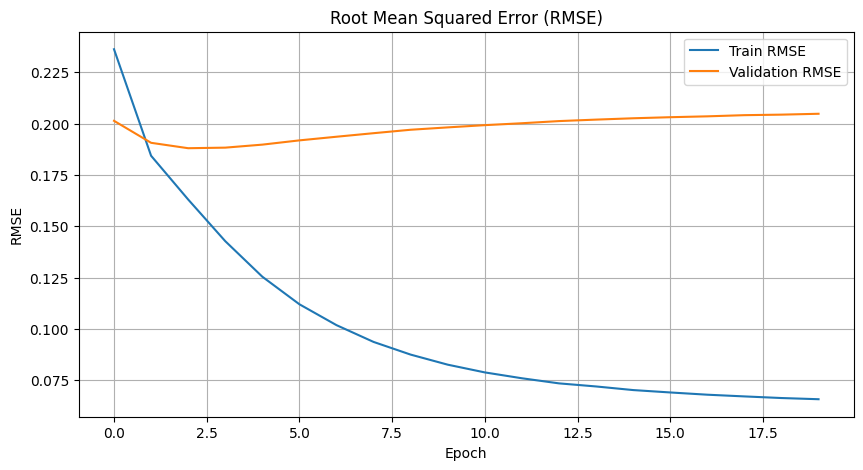

In [55]:
# Visualisasi RMSE
plt.figure(figsize=(10, 5))
plt.plot(rmse_train, label='Train RMSE')
plt.plot(rmse_val, label='Validation RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

**Analisis:**
- RMSE Train:  0.0658
- RMSE Val:  0.2047
- Grafik menunjukkan bahwa:
  - RMSE training menurun konsisten dari awal hingga akhir epoch, menunjukkan bahwa model belajar dengan baik pada data pelatihan.
  - RMSE validasi menurun sedikit hingga sekitar epoch ke-2, kemudian mulai meningkat perlahan setelahnya.
- Terdapat indikasi overfitting pada model, yang terlihat dari perbedaan antara nilai RMSE training dan RMSE validasi. Nilai RMSE training terus menurun secara konsisten, menandakan model semakin baik dalam mempelajari data pelatihan. Namun, RMSE validasi hanya menurun pada beberapa epoch awal (sekitar epoch ke-2), lalu meningkat perlahan setelahnya. Hal ini menunjukkan bahwa model mulai kehilangan kemampuan generalisasi terhadap data baru, karena terlalu menyesuaikan diri dengan data pelatihan.

**Mean Absolute Error (MAE)**

In [56]:
mae_train = history.history['mean_absolute_error']
mae_val = history.history['val_mean_absolute_error']

print('MAE Train: ', mae_train[-1])
print('MAE Val: ', mae_val[-1])

MAE Train:  0.05028863623738289
MAE Val:  0.15698374807834625


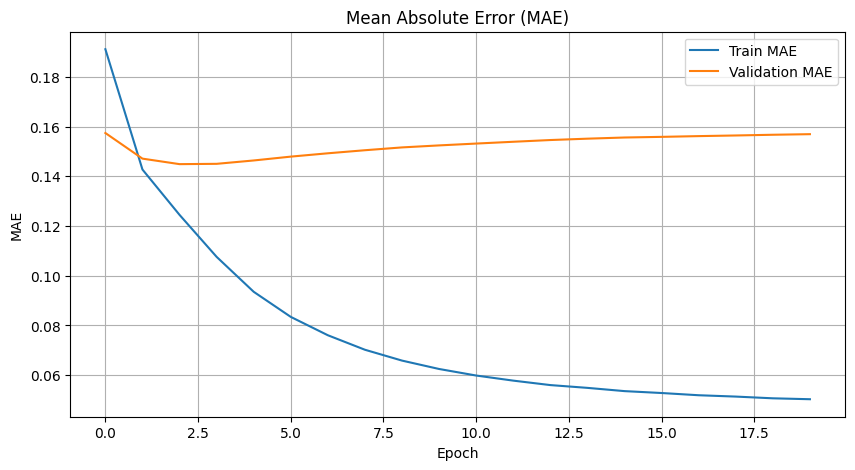

In [57]:
# Visualisasi MAE
plt.figure(figsize=(10, 5))
plt.plot(mae_train, label='Train MAE')
plt.plot(mae_val, label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

**Analisis:**
- MAE Train:  0.0502
- MAE Val:  0.1569
- Grafik menunjukkan bahwa:
  - MAE training juga menurun tajam dan konsisten, mendekati nilai minimum sekitar 0.05.
  - MAE validasi mencapai titik terendah di sekitar epoch ke-2 hingga ke-3, lalu meningkat perlahan dan cukup stabil.
- Sama seperti RMSE, grafik MAE menunjukkan overfitting setelah beberapa epoch awal. Kecenderungan validasi MAE untuk stagnan atau naik menandakan model hanya bagus pada data training.